<center> <span style="color:indigo">Machine Learning e Inferencia Bayesiana</span> </center> 

<div style="text-align: center;">
<img src="../Imagenes/CUGDL_logo.png" alt="Drawing" style="width: 800px;"/>
</div>

<center> <span style="color:DarkBlue">  Tema 5. Validación y control de sobreajuste: Regularización con Ridge y Lasso</span>  </center>
<center> <span style="color:Blue"> Profesor: M. en C. Iván A. Toledano Juárez </span>  </center>

# Regularización con Ridge y Lasso: Comparación con regresión lineal tradicional

## Introducción

En temas anteriores aprendimos a evaluar modelos de regresión lineal de forma más confiable utilizando división de datos y validación cruzada. En esta ocasión, nos enfrentamos a una pregunta común en ciencia de datos:

> ¿Qué sucede cuando el modelo comienza a sobreajustar debido al exceso de variables o a la multicolinealidad?

Cuando un modelo de regresión lineal utiliza muchas variables o se enfrenta a variables altamente correlacionadas entre sí, los coeficientes pueden volverse inestables y exagerados. Esto afecta la capacidad del modelo para generalizar a datos nuevos, incluso si sus métricas en entrenamiento son buenas.

Para abordar este problema, introduciremos dos técnicas de **regularización**: **Ridge** y **Lasso**. Estas técnicas modifican la función de costo del modelo al agregar una penalización que controla la magnitud de los coeficientes, lo que ayuda a prevenir el sobreajuste.

### ¿Qué es una función de costo (loss function)?

En aprendizaje automático supervisado, y particularmente en regresión, el objetivo de un modelo es **aprender una función que minimice el error** entre las predicciones del modelo ($\hat{y}$) y los valores reales ($y$).

Para cuantificar ese error, utilizamos una **función de costo** (también llamada **función de pérdida**, o *loss function*), que mide qué tan mal lo está haciendo el modelo. En la regresión lineal tradicional, la función de costo más común es el **Error Cuadrático Medio** (MSE), que se define como:

\begin{equation}
\text{MSE} = \frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2
\end{equation}

El proceso de entrenamiento del modelo consiste en **ajustar los coeficientes** para **minimizar esta función de costo**.

---

Las técnicas de regularización como **Ridge** y **Lasso** modifican esta función de costo al agregar un **término adicional de penalización**, que limita la magnitud de los coeficientes para evitar sobreajuste. A estas funciones modificadas también se les llama funciones de costo regularizadas.

A continuación, veremos cómo se definen las funciones de costo en Ridge y Lasso.


---

## Regresión Ridge (L2)

Ridge agrega una penalización proporcional al **cuadrado de los coeficientes**. La función de costo modificada es:

\begin{equation}
\text{Loss}_{\text{Ridge}} = \sum_{i=1}^{n} (y_i - \hat{y}_i)^2 + \lambda \sum_{j=1}^{p} \beta_j^2
\end{equation}

Donde:
- $y_i$ es el valor real,
- $\hat{y}_i$ es la predicción del modelo,
- $\beta_j$ son los coeficientes del modelo,
- $\lambda$ es el parámetro de regularización.

Ridge **reduce todos los coeficientes**, pero **ninguno llega exactamente a cero**. Es útil cuando se cree que **todas las variables aportan algo**, aunque sea poco.

---

## Regresión Lasso (L1)

Lasso, por otro lado, utiliza la **suma de los valores absolutos** de los coeficientes como penalización:

\begin{equation}
\text{Loss}_{\text{Lasso}} = \sum_{i=1}^{n} (y_i - \hat{y}_i)^2 + \lambda \sum_{j=1}^{p} |\beta_j|
\end{equation}

Esta penalización tiene un efecto interesante: puede forzar **algunos coeficientes a ser exactamente cero**, lo que implica una **selección automática de variables**. Es especialmente útil cuando se sospecha que solo **algunas variables son realmente importantes**.

---

En ambos casos, el parámetro $\lambda$ controla el grado de penalización:
- Si $\lambda = 0$, recuperamos la **regresión lineal tradicional**.
- A mayor $\lambda$, mayor es la penalización y más pequeños (o nulos, en el caso de Lasso) serán los coeficientes.

A lo largo de este notebook, exploraremos estas ideas de forma práctica utilizando el dataset **California Housing**, con el objetivo de comparar estas técnicas con la regresión lineal convencional y visualizar cómo afecta la regularización a los coeficientes del modelo.

---


In [1]:
# Importación de librerías
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, Lasso, LassoCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import cross_val_score

## Carga de datos y división en conjunto de entrenamiento y prueba

In [2]:
# Cargar datos como DataFrame
data = fetch_california_housing(as_frame=True)
X = data.data
y = data.target

# División entrenamiento/prueba (80/20)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)
display(X)

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25
...,...,...,...,...,...,...,...,...
20635,1.5603,25.0,5.045455,1.133333,845.0,2.560606,39.48,-121.09
20636,2.5568,18.0,6.114035,1.315789,356.0,3.122807,39.49,-121.21
20637,1.7000,17.0,5.205543,1.120092,1007.0,2.325635,39.43,-121.22
20638,1.8672,18.0,5.329513,1.171920,741.0,2.123209,39.43,-121.32


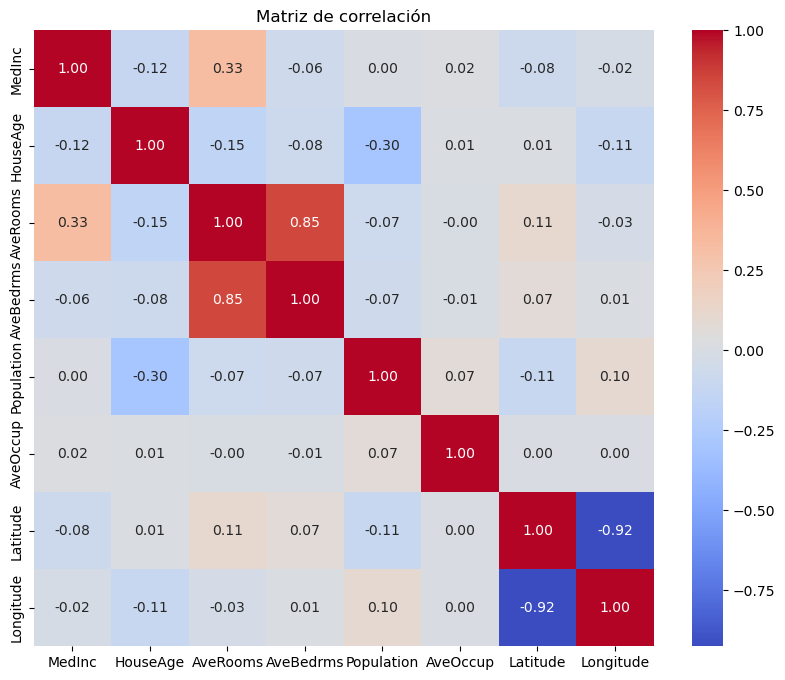

In [3]:
# Mapa de correlaciones
plt.figure(figsize=(10, 8))
sns.heatmap(X.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Matriz de correlación")
plt.show()

## Modelo base: Regresión Lineal tradicional

Comenzamos ajustando un modelo de regresión lineal múltiple utilizando el conjunto de entrenamiento, y evaluamos su desempeño en el conjunto de prueba.

Este modelo servirá como **línea base de comparación** para los modelos regularizados que veremos a continuación.


In [4]:
def model_coef(model):
    print('ß0: ', round(model.intercept_,3))
    for i in range(0, len(model.coef_)):
        print('ß'+str(i+1)+': ', round(model.coef_[i],3), 'asociado a variable', model.feature_names_in_[i])

In [5]:
lr = LinearRegression() # 1. Instanciamos el modelo LinearRegression
lr.fit(X_train, y_train) # 2. Entrenamiento (con datos de entrenamiento)

y_pred_lr = lr.predict(X_test) # 3. Predicciones (con datos de prueba)
mae_lr = mean_absolute_error(y_test, y_pred_lr) # 4. Evaluación con métricas (con datos de prueba)
mse_lr = mean_squared_error(y_test, y_pred_lr) 
r2_lr = r2_score(y_test, y_pred_lr)

model_coef(lr) # función personalizada que muestra los coeficientes beta

print("Métricas Regresión Lineal (tradicional):")
print(f"MAE: {mae_lr:.3f}")
print(f"MSE: {mse_lr:.3f}")
print(f"R2:  {r2_lr:.3f}")

ß0:  -37.023
ß1:  0.449 asociado a variable MedInc
ß2:  0.01 asociado a variable HouseAge
ß3:  -0.123 asociado a variable AveRooms
ß4:  0.783 asociado a variable AveBedrms
ß5:  -0.0 asociado a variable Population
ß6:  -0.004 asociado a variable AveOccup
ß7:  -0.42 asociado a variable Latitude
ß8:  -0.434 asociado a variable Longitude
Métricas Regresión Lineal (tradicional):
MAE: 0.533
MSE: 0.556
R2:  0.576


## Modelo Ridge (regresión con regularización L2)

A continuación entrenamos un modelo de **Ridge Regression**, que introduce una penalización L2 para reducir la magnitud de los coeficientes.

Utilizaremos un valor inicial de $\alpha = 1.0$, que es el valor por defecto en `scikit-learn`. Más adelante ajustaremos este parámetro mediante validación cruzada.


In [6]:
ridge = Ridge(alpha=1.0) # 1. Instanciamos el modelo Ridge Regression (hiperparámetro alpha se refiere a lambda en la introduccion)
ridge.fit(X_train, y_train) # 2. Entrenamiento (con datos de entrenamiento)

y_pred_ridge = ridge.predict(X_test) # 3. Predicciones (con datos de prueba)
mae_ridge = mean_absolute_error(y_test, y_pred_ridge) # 4. Evaluación con métricas (con datos de prueba)
mse_ridge = mean_squared_error(y_test, y_pred_ridge) 
r2_ridge = r2_score(y_test, y_pred_ridge)

model_coef(ridge)

print("Métricas Regresión Lineal (Ridge):")
print(f"MAE: {mae_ridge:.3f}")
print(f"MSE: {mse_ridge:.3f}")
print(f"R2:  {r2_ridge:.3f}")

ß0:  -37.019
ß1:  0.449 asociado a variable MedInc
ß2:  0.01 asociado a variable HouseAge
ß3:  -0.123 asociado a variable AveRooms
ß4:  0.781 asociado a variable AveBedrms
ß5:  -0.0 asociado a variable Population
ß6:  -0.004 asociado a variable AveOccup
ß7:  -0.42 asociado a variable Latitude
ß8:  -0.434 asociado a variable Longitude
Métricas Regresión Lineal (Ridge):
MAE: 0.533
MSE: 0.556
R2:  0.576


Ridge aplica una penalización suave que tiende a **reducir todos los coeficientes**, pero sin forzarlos a cero. En comparación con la regresión lineal tradicional, puede obtener un **ligero ajuste en las métricas** y una mejor estabilidad del modelo, especialmente cuando hay variables correlacionadas. 

## Modelo Lasso (regresión con regularización L1)

Ahora entrenamos un modelo de **Lasso Regression**, que introduce una penalización L1. Esta penalización tiene la particularidad de que puede llevar **algunos coeficientes a cero**, lo cual equivale a **eliminar variables automáticamente** del modelo.

Comenzamos utilizando $\alpha = 1.0$, aunque más adelante exploraremos cómo este valor afecta el comportamiento del modelo.



In [7]:
lasso = Lasso(alpha=0.02, max_iter=10000) # 1. Instanciamos el modelo Lasso Regression (hiperparámetro alpha se refiere a lambda en la introduccion)
lasso.fit(X_train, y_train) # 2. Entrenamiento (con datos de entrenamiento)

model_coef(lasso)

y_pred_lasso = lasso.predict(X_test) # 3. Predicciones (con datos de prueba)
mae_lasso = mean_absolute_error(y_test, y_pred_lasso) # 4. Evaluación con métricas (con datos de prueba)
mse_lasso = mean_squared_error(y_test, y_pred_lasso)
r2_lasso = r2_score(y_test, y_pred_lasso)

print("Métricas Regresión Lineal (Lasso):")
print(f"MAE: {mae_lasso:.3f}")
print(f"MSE: {mse_lasso:.3f}")
print(f"R2:  {r2_lasso:.3f}")


ß0:  -32.394
ß1:  0.384 asociado a variable MedInc
ß2:  0.011 asociado a variable HouseAge
ß3:  0.0 asociado a variable AveRooms
ß4:  0.075 asociado a variable AveBedrms
ß5:  0.0 asociado a variable Population
ß6:  -0.003 asociado a variable AveOccup
ß7:  -0.384 asociado a variable Latitude
ß8:  -0.387 asociado a variable Longitude
Métricas Regresión Lineal (Lasso):
MAE: 0.542
MSE: 0.548
R2:  0.582


En este caso, el modelo Lasso puede mostrar métricas similares a las de Ridge y la regresión lineal tradicional si $\alpha$ no es suficientemente grande. Sin embargo, una diferencia clave es que **algunos coeficientes pueden haberse reducido exactamente a cero**, eliminando así ciertas variables del modelo.

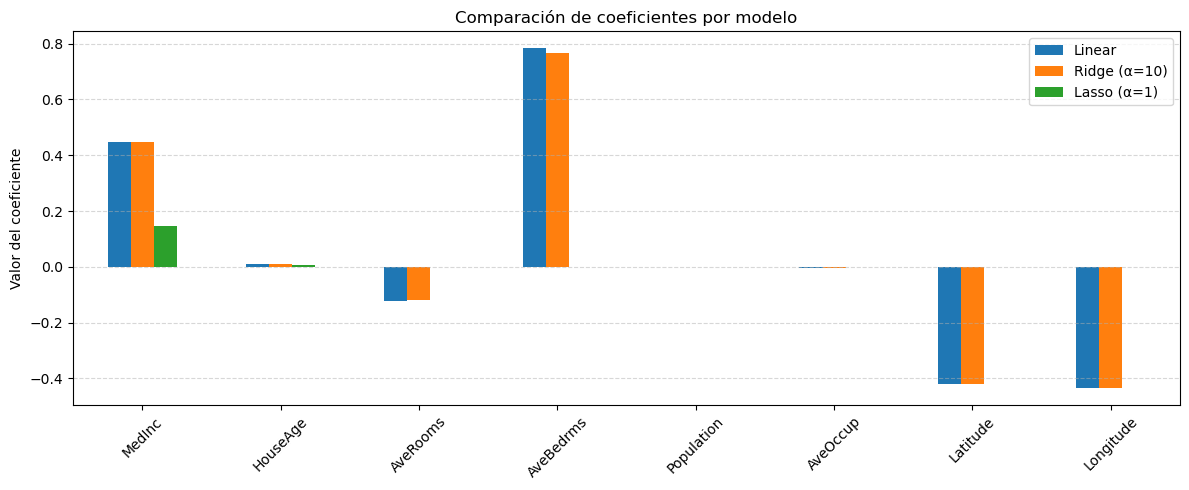

In [8]:
# Entrenamos de nuevo Ridge con alpha más grande
ridge10 = Ridge(alpha=10)
ridge10.fit(X_train, y_train)

# Entrenamos de nuevo Lasso por claridad
lasso1 = Lasso(alpha=1, max_iter=10000)
lasso1.fit(X_train, y_train)

# Creamos DataFrame con coeficientes

coef_df = pd.DataFrame({
    "Linear": lr.coef_,
    "Ridge (α=10)": ridge10.coef_,
    "Lasso (α=1)": lasso1.coef_
}, index=X.columns)

# Gráfico de barras
coef_df.plot(kind="bar", figsize=(12, 5))
plt.title("Comparación de coeficientes por modelo")
plt.ylabel("Valor del coeficiente")
plt.grid(True, axis="y", linestyle="--", alpha=0.5)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

En el gráfico anterior podemos que:

- El modelo Ridge reduce la magnitud de los coeficientes, pero conserva todos.
- Lasso elimina completamente algunas variables (coeficientes en cero), lo que permite **seleccionar automáticamente características**.
- La regresión lineal tradicional muestra los coeficientes sin restricciones, lo que puede ser problemático si hay multicolinealidad.

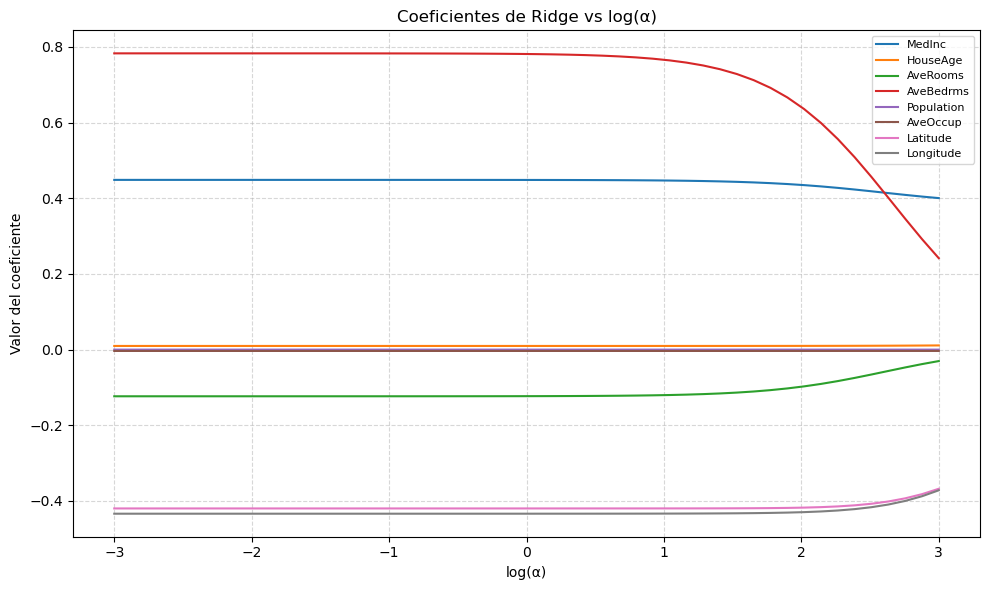

In [9]:
# Valores de alpha sobre escala logarítmica (Ridge)
alphas = np.logspace(-3, 3, 50)  # de 0.001 a 1000
coefs = []

for alpha in alphas:
    ridge = Ridge(alpha=alpha)
    ridge.fit(X_train, y_train)
    coefs.append(ridge.coef_)

coefs = np.array(coefs)

# Gráfico
plt.figure(figsize=(10, 6))
for i in range(coefs.shape[1]):
    plt.plot(np.log10(alphas), coefs[:, i], label=X.columns[i])

plt.title("Coeficientes de Ridge vs log(α)")
plt.xlabel("log(α)")
plt.ylabel("Valor del coeficiente")
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.legend(fontsize=8)
plt.show()

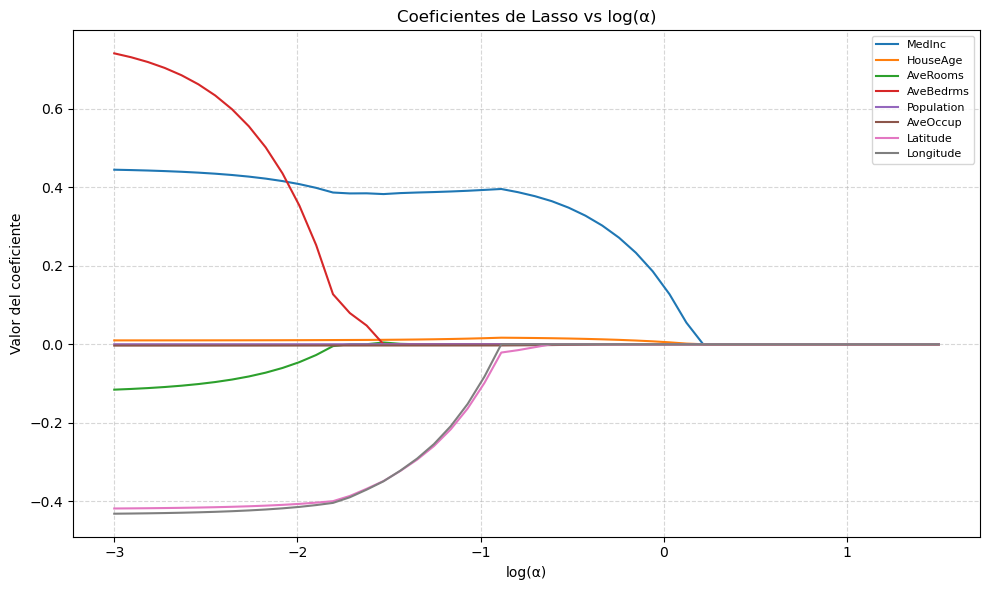

In [10]:
# Valores de alpha sobre escala logarítmica (Lasso)
alphas = np.logspace(-3, 1.5, 50)  # de 0.001 a 1000
coefs = []

for alpha in alphas:
    lasso = Lasso(alpha=alpha, max_iter=10000)
    lasso.fit(X_train, y_train)
    coefs.append(lasso.coef_)

coefs = np.array(coefs)

# Gráfico
plt.figure(figsize=(10, 6))
for i in range(coefs.shape[1]):
    plt.plot(np.log10(alphas), coefs[:, i], label=X.columns[i])

plt.title("Coeficientes de Lasso vs log(α)")
plt.xlabel("log(α)")
plt.ylabel("Valor del coeficiente")
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.legend(fontsize=8)
plt.show()

## Selección automática del parámetro $\alpha$ con validación cruzada

Hasta ahora hemos elegido valores de $\alpha$ de forma manual para Ridge y Lasso. Sin embargo, elegir el valor más adecuado puede marcar una diferencia significativa en el desempeño del modelo.

Una forma eficiente de encontrar el mejor $\alpha$ es usar **validación cruzada interna**, lo que permite evaluar múltiples valores y seleccionar el que genera mejores resultados.

A continuación, usamos `RidgeCV` y `LassoCV`, versiones de los modelos que incorporan este proceso de validación de forma automática.


In [11]:
# Lista de alphas a probar
alphas_ridge = np.logspace(-3, 3, 50)

ridge_cv = RidgeCV(alphas=alphas_ridge, store_cv_results=True, scoring='neg_root_mean_squared_error') # la métrica base la elegimos, aquí es rmse
ridge_cv.fit(X_train, y_train)

# Evaluación
y_pred_ridgecv = ridge_cv.predict(X_test)
print(f"RidgeCV — Mejor α: {ridge_cv.alpha_:.4f}")
print(f"MAE: {mean_absolute_error(y_test, y_pred_ridgecv):.3f}")
print(f"MSE: {mean_squared_error(y_test, y_pred_ridgecv):.3f}")
print(f"R2:  {r2_score(y_test, y_pred_ridgecv):.3f}")

RidgeCV — Mejor α: 8.2864
MAE: 0.533
MSE: 0.555
R2:  0.576


In [12]:
# Lista de alphas a probar
alphas_lasso = np.logspace(-3, 1.5, 50)

lasso_cv = LassoCV(alphas=alphas_lasso, cv=5, max_iter=10000) # la métrica de referencia siempre es mse
lasso_cv.fit(X_train, y_train)

# Evaluación
y_pred_lassocv = lasso_cv.predict(X_test)
print(f"LassoCV — Mejor α: {lasso_cv.alpha_:.4f}")
print(f"MAE: {mean_absolute_error(y_test, y_pred_lassocv):.3f}")
print(f"MSE: {mean_squared_error(y_test, y_pred_lassocv):.3f}")
print(f"R2:  {r2_score(y_test, y_pred_lassocv):.3f}")


LassoCV — Mejor α: 0.0010
MAE: 0.533
MSE: 0.554
R2:  0.577


Con `RidgeCV` y `LassoCV`, hemos automatizado la búsqueda del parámetro de regularización $\alpha$, permitiendo que el modelo elija la mejor opción con base en validación cruzada.

Esto no solo mejora el rendimiento general, sino que también elimina la necesidad de seleccionar arbitrariamente un valor de $\alpha$. Estas herramientas son fundamentales para construir modelos más robustos y confiables. Estos modelos pueden ser utilizados dentro de pipelines de machine learning para automatizar el proceso.

## Resumen y conclusiones

En este notebook exploramos cómo las técnicas de **regularización** pueden ayudarnos a construir modelos de regresión más robustos, especialmente en contextos donde existe riesgo de **sobreajuste** o cuando se trabaja con muchas variables.

### ¿Qué aprendimos?

- **Regresión lineal tradicional** puede ser sensible a la colinealidad o a la complejidad del modelo.
- **Ridge Regression** (penalización L2) reduce todos los coeficientes pero no los elimina. Es útil cuando todas las variables aportan algo.
- **Lasso Regression** (penalización L1) puede reducir algunos coeficientes exactamente a cero, permitiendo una **selección automática de variables**.
- A través de las gráficas de **coeficientes vs log(α)**, visualizamos cómo los modelos se simplifican conforme aumenta la regularización.
- Usamos **`RidgeCV`** y **`LassoCV`** para automatizar la búsqueda del valor óptimo de $\alpha$, seleccionando el modelo que mejor generaliza según el error cuadrático medio.

### Reflexión práctica

Aunque en este conjunto de datos las diferencias en métricas no fueron dramáticas, observamos cómo la regularización **modifica la estructura interna del modelo**, lo que puede tener un impacto importante en interpretabilidad y estabilidad, especialmente en datasets con alta dimensionalidad o ruido.

En la siguiente unidad abordaremos modelos para **clasificación**, comenzando con la **regresión logística**, que comparte fundamentos con la regresión lineal pero adaptados a variables objetivo categóricas.

---

